In [76]:
# Step 1: Load the annthyroid dataset and explore basic info

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_path = "annthyroid_unsupervised_anomaly_detection.csv"

df = pd.read_csv(data_path, sep=";")
df.columns = df.columns.str.strip().str.replace(";", "", regex=False)

df_clean = df.drop(columns=["Unnamed: 22", "Unnamed: 23"])
X = df_clean

In [77]:
# 从原始数据加载，保存为.csv文件，并进行了相应调整（省略）
# df_raw = pd.read_csv(R"D:\Download\thyroid+disease\dis.data", header=None)
# print("Raw DataFrame shape:", df_raw.shape)
# df_raw.to_csv("thyroid_raw_data.csv", index=False)

In [78]:
# Load the thyroid raw data
file_name = "thyroid_raw_data.csv"
df_raw = pd.read_csv(file_name)
print("Raw DataFrame shape:", df_raw.shape)

Raw DataFrame shape: (2800, 30)


In [79]:
binary_features = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 
                  'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 
                  'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych']
# 激素测量值列名映射
hormone_mapping = {
    'TSH': 'TSH',
    'T3_measured': 'T3',
    'TT4_measured': 'TT4', 
    'T4U_measured': 'T4U',
    'FTI_measured': 'FTI'
}

# 反向映射
reverse_hormone_mapping = {v: k for k, v in hormone_mapping.items()}
# print("Hormone mapping:", reverse_hormone_mapping)

In [80]:
def value_match_with_tolerance(val_raw, val_processed, tolerance=1e-2):
    """匹配数值特征，允许一定的容差"""
    try:
        val_raw = float(val_raw)
        val_processed = float(val_processed)
        for t in [10**i for i in range(-5, 6)]:
            val_mul = val_processed * t
            # print(f"Testing: raw={val_raw}, processed={val_processed}, mul={val_mul}, tolerance={tolerance}")
            if abs((val_raw - val_mul) / val_raw) <= tolerance:
                return True, t
        return False, 0
    except:
        return False, 0

def match_rows(df_raw_row, df_processed_row, hormone_mapping):
    """匹配原始数据行和处理后数据行的特征值"""
    mul = []
    for hormone in hormone_mapping.keys():
        raw_col = hormone_mapping[hormone]
        val_raw = df_raw_row[raw_col]
        val_processed = df_processed_row[hormone]
        success, multiplier =  value_match_with_tolerance(val_raw, val_processed)
        if not success:
            return False, mul
        mul.append(multiplier)
    
    return True, mul

# Filter valid rows without missing hormone values
invalid_group = df_raw[hormone_mapping.values()].isin(['?']).any(axis=1)
invalid_group = invalid_group | df_raw[binary_features].isin(['?']).any(axis=1)
invalid_group = invalid_group | df_raw[['Age']].isin(['?']).any(axis=1)
invalid_group = invalid_group | df_raw[['Sex']].isin(['?']).any(axis=1)

# get index of rows without missing hormone values
valid_indices = df_raw[~invalid_group].index.tolist()
print("Number of valid rows without missing hormone values:", len(valid_indices))
# Filtered valid raw DataFrame
df_raw_valid = df_raw.loc[valid_indices]
print("Valid Raw DataFrame shape:", df_raw_valid.shape)

# 随机选择一些索引进行比较
index_group = np.random.choice(df_raw_valid.index, size=10, replace=False)
index_group = df_raw_valid.index
print("Random index for comparison:", len(index_group), index_group[:10])

hormone_dicts = {"0": "TSH", "1": "T3", "2": "TT4", "3": "T4U", "4": "FTI"}
count_dicts = {hormone_dicts[str(i)]: {} for i in range(5)}

for index in index_group:
    df_raw_row = df_raw_valid.loc[index]
    # 根据年龄和性别筛选可能的匹配行
    raw_age = float(df_raw_row['Age'])
    valid_X = X[(X['Age'] == raw_age) | (X['Age']*100 == raw_age)]
    valid_X = valid_X[(valid_X['Sex'] == 1) & (df_raw_row['Sex'] == 'M') | (valid_X['Sex'] == 0) & (df_raw_row['Sex'] == 'F')]
    for feature in binary_features:
        valid_X = valid_X[(valid_X[feature] == 1 & (df_raw_row[feature] == 't') )| (valid_X[feature] == 0 & (df_raw_row[feature] == 'f'))]
    # print(f"Index {index}: Raw age={raw_age}, matched processed rows count={len(valid_X)}")
    index_group = []
    mul = []
    # 尝试匹配每一行
    for row in valid_X.index:
        df_processed_row = valid_X.loc[row]
        success, mul_temp = match_rows(df_raw_row, df_processed_row, hormone_mapping)
        if success:
            index_group.append(row)
            mul = mul_temp
    
    # 输出匹配结果
    if 1e-05 in mul:
        print(f"Index {index} matched processed indices: {index_group} with multipliers: {mul}")
        display(X.loc[index_group, hormone_mapping.keys()])
        display(df_raw.loc[[index], hormone_mapping.values()])
    
    # 记录每个激素的匹配倍数
    for i, m in enumerate(mul):
        hormone = hormone_dicts[str(i)]
        if count_dicts[hormone].get(m) is None:
            count_dicts[hormone][m] = 1
        count_dicts[hormone][m] = count_dicts[hormone].get(m, 0) + 1
    
# 输出每个激素的匹配计数
for key, value in count_dicts.items():
    print(f"hormone: {key}, Multiplier Count: {value}")

Number of valid rows without missing hormone values: 1947
Valid Raw DataFrame shape: (1947, 30)
Random index for comparison: 1947 Index([0, 4, 7, 8, 9, 10, 12, 13, 14, 17], dtype='int64')
hormone: TSH, Multiplier Count: {1000: 1362, 1: 126}
hormone: T3, Multiplier Count: {0.1: 1238, 100: 250}
hormone: TT4, Multiplier Count: {1: 1330, 1000: 158}
hormone: T4U, Multiplier Count: {0.01: 1328, 10: 160}
hormone: FTI, Multiplier Count: {1: 1329, 1000: 159}


TSH measured='t' samples shape: (2516, 30)
TSH value statistics:
count    2516.000000
mean        4.672150
std        21.449453
min         0.005000
25%         0.440000
50%         1.400000
75%         2.600000
max       478.000000
Name: TSH, dtype: float64
TSH value statistics on X:
count    6916.000000
mean        1.603466
std        14.047218
min         0.000000
25%         0.000680
50%         0.001700
75%         0.002700
max       494.000000
Name: TSH, dtype: float64
T3 measured='t' samples shape: (2215, 30)
T3 value statistics:
count    2215.000000
mean        2.024966
std         0.824600
min         0.050000
25%         1.600000
50%         2.000000
75%         2.400000
max        10.600000
Name: T3, dtype: float64
T3 value statistics on X:
count    6916.000000
mean       11.772446
std        11.836250
min         0.000500
25%         0.020100
50%        13.000000
75%        22.000000
max        95.000000
Name: T3_measured, dtype: float64
TT4 measured='t' samples shape: (261

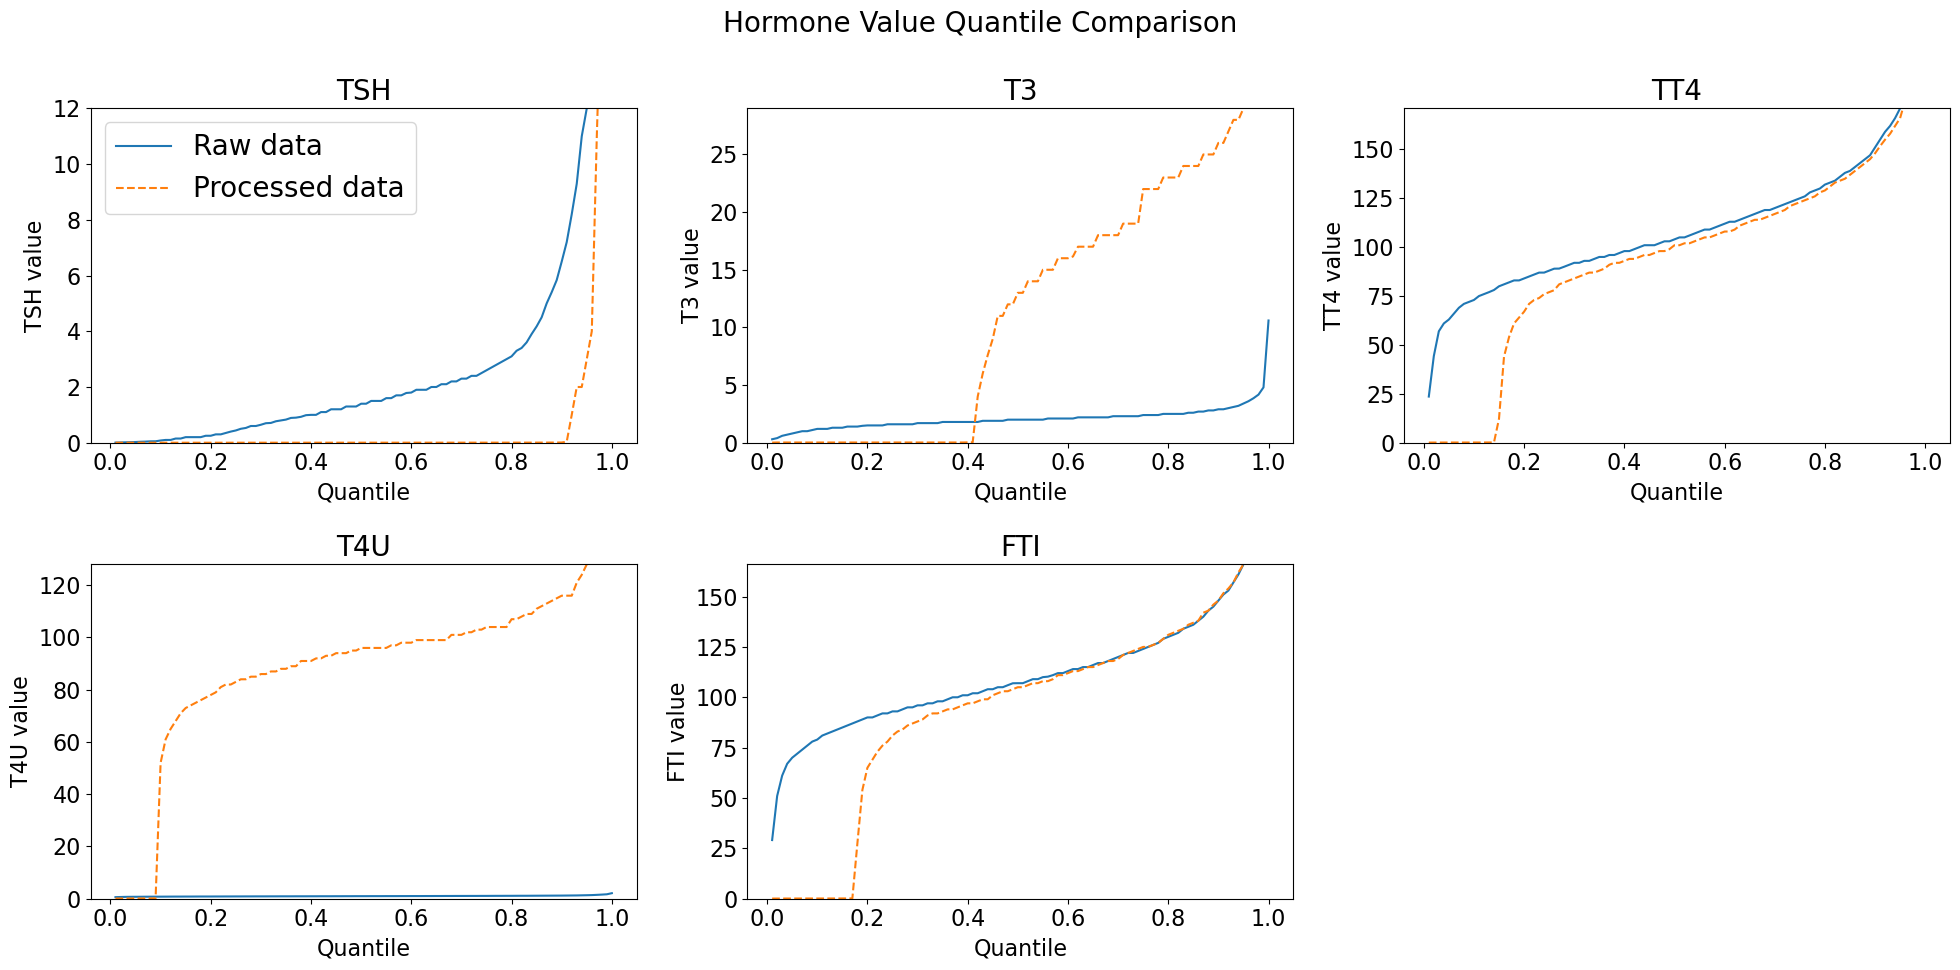

Quatile group (25% and 75%): {'TSH': {'min': 0.005, '25%': 0.44, '75%': 2.6, 'max': 478.0}, 'T3': {'min': 0.05, '25%': 1.6, '75%': 2.4, 'max': 10.6}, 'TT4': {'min': 2.0, '25%': 88.0, '75%': 125.0, 'max': 430.0}, 'T4U': {'min': 0.31, '25%': 0.88, '75%': 1.08, 'max': 2.12}, 'FTI': {'min': 2.0, '25%': 93.0, '75%': 124.0, 'max': 395.0}}


In [81]:
# 筛选measured为't'的样本，统计各激素值分布
plt.rcParams.update({
    'font.size': 20,           # 默认字体大小
    'axes.titlesize': 20,      # 子图标题大小
    'axes.labelsize': 16,      # 坐标轴标签大小
    'xtick.labelsize': 16,     # x轴刻度标签大小
    'ytick.labelsize': 16,     # y轴刻度标签大小
    'legend.fontsize': 20,     # 图例字体大小
    'figure.titlesize': 20     # 总标题大小
})

def plot_different(legend_list = ['Raw data', 'Processed data']):
    plt.figure(figsize=(20, 10))
    plt.suptitle("Hormone Value Quantile Comparison")
    # use the same legend
    index = 1
    quatile_group = {}
    for harmone in ['TSH', 'T3', 'TT4', 'T4U', 'FTI']:
        plt.subplot(2, 3, index)
        index += 1
        measured_col = f"{harmone}_" + "measured"
        df_measured = df_raw[df_raw[measured_col] == 't'].copy()
        print(f"{harmone} measured='t' samples shape:", df_measured.shape)
        print(f"{harmone} value statistics:")
        # change type to numeric
        print(pd.to_numeric(df_measured[harmone], errors='coerce').describe())
        print(f"{harmone} value statistics on X:")
        try:
            print(X[harmone].describe())
        except:
            print(X[harmone + '_' + 'measured'].describe())
        # plot in bins
        harmone_values = pd.to_numeric(df_measured[harmone].copy(), errors='coerce')
        X_harmone_values = pd.to_numeric(X[harmone if harmone in X.columns else harmone + '_' + 'measured'].copy(), errors='coerce')
        # plot 1-100 quatile
        quatile = harmone_values.quantile([0.01 * t for t in range(1, 101)])
        quatile_group[harmone] = {'min': np.min(harmone_values), '25%': quatile.loc[0.25], '75%': quatile.loc[0.75], 'max': np.max(harmone_values)}
        # 保持25%和75%分位数到quatile_group
        X_quantile = X_harmone_values.quantile([0.01 * t for t in range(1, 101)])
        plt.plot(quatile.index, quatile.values)
        plt.plot(X_quantile.index, X_quantile.values, linestyle='--')
        
        if index == 2:  # 添加图例
            plt.legend(legend_list)
            
        plt.ylim(0, max(np.percentile(harmone_values.dropna(), 95), np.percentile(X_harmone_values.dropna(), 95)))
        plt.title(f"{harmone}")
        plt.xlabel("Quantile")
        plt.ylabel(f"{harmone} value")
    plt.tight_layout()
    plt.show()
    return quatile_group

quatile_group = plot_different()
print("Quatile group (25% and 75%):", quatile_group)


TSH measured='t' samples shape: (2516, 30)
TSH value statistics:
count    2516.000000
mean        4.672150
std        21.449453
min         0.005000
25%         0.440000
50%         1.400000
75%         2.600000
max       478.000000
Name: TSH, dtype: float64
TSH value statistics on X:
count    6916.000000
mean        3.243423
std        13.986127
min         0.005000
25%         0.677500
50%         1.600000
75%         2.400000
max       494.000000
Name: TSH, dtype: float64
T3 measured='t' samples shape: (2215, 30)
T3 value statistics:
count    2215.000000
mean        2.024966
std         0.824600
min         0.050000
25%         1.600000
50%         2.000000
75%         2.400000
max        10.600000
Name: T3, dtype: float64
T3 value statistics on X:
count    6916.000000
mean        2.094754
std         0.801561
min         0.050000
25%         1.800000
50%         2.010000
75%         2.200000
max        18.000000
Name: T3_measured, dtype: float64
TT4 measured='t' samples shape: (261

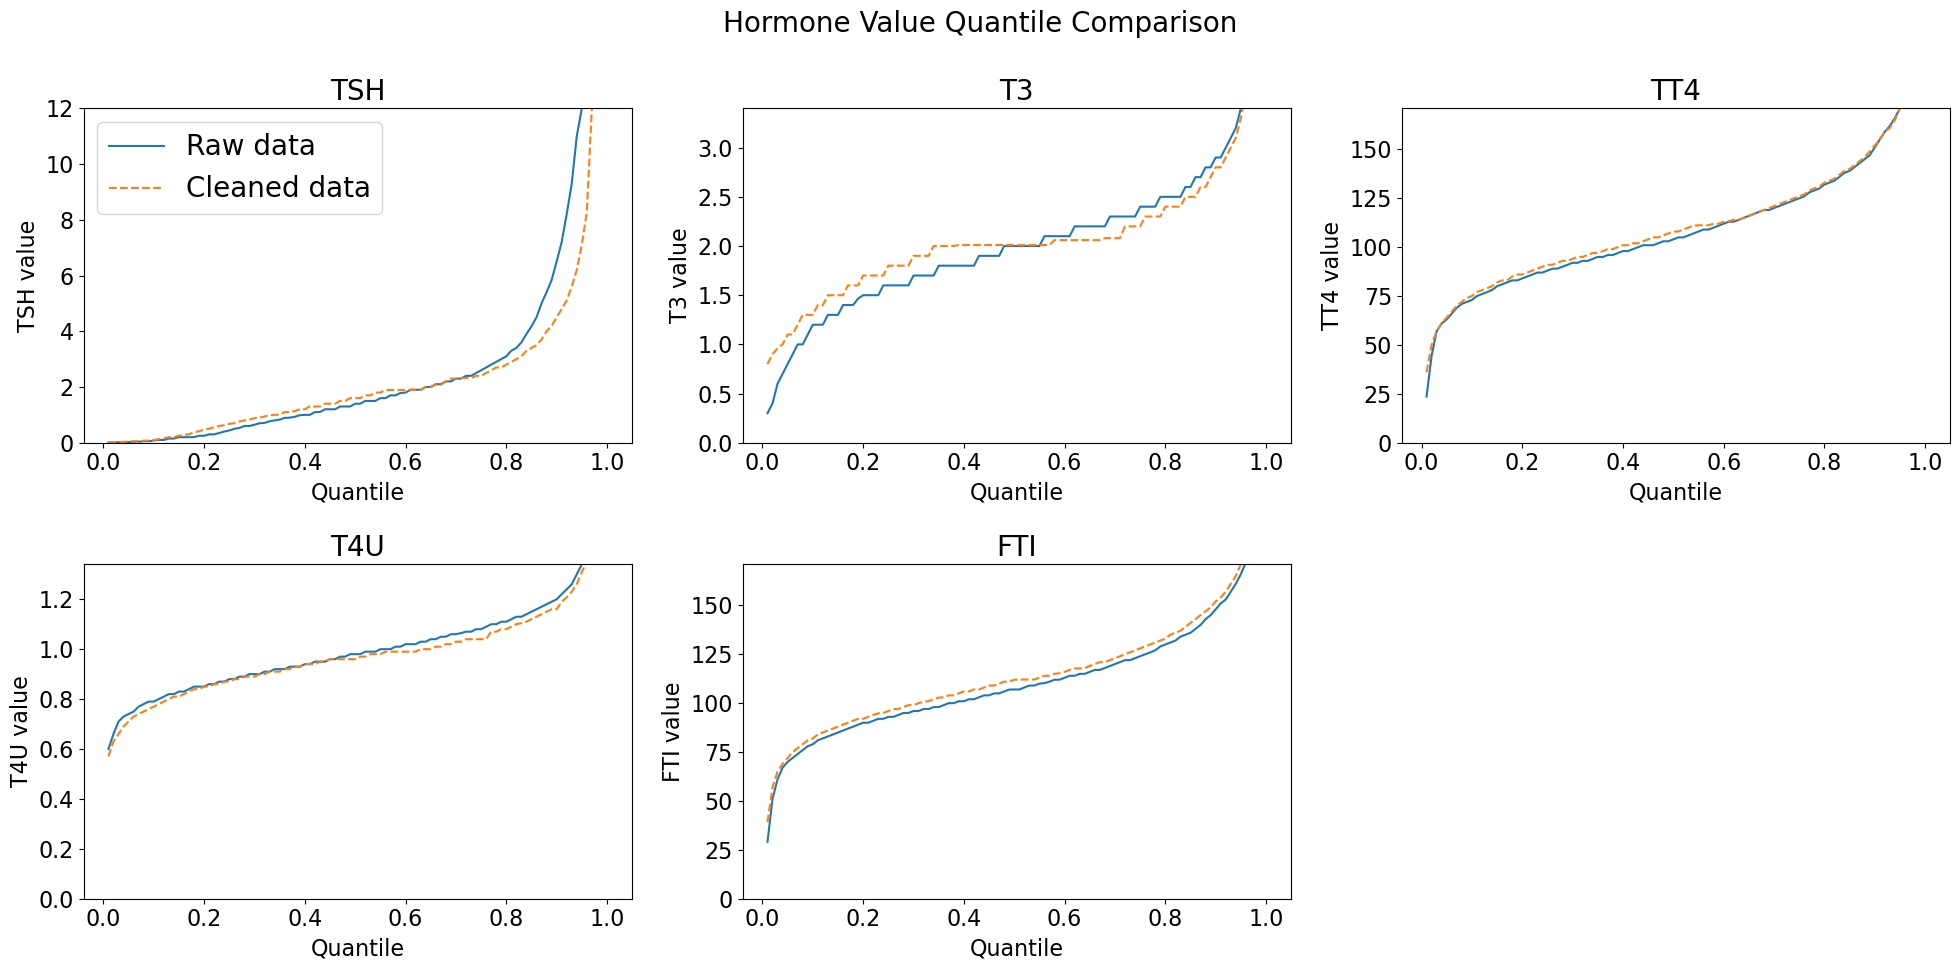

{'TSH': {'min': 0.005, '25%': 0.44, '75%': 2.6, 'max': 478.0},
 'T3': {'min': 0.05, '25%': 1.6, '75%': 2.4, 'max': 10.6},
 'TT4': {'min': 2.0, '25%': 88.0, '75%': 125.0, 'max': 430.0},
 'T4U': {'min': 0.31, '25%': 0.88, '75%': 1.08, 'max': 2.12},
 'FTI': {'min': 2.0, '25%': 93.0, '75%': 124.0, 'max': 395.0}}

In [82]:
# df = pd.read_csv(data_path, sep=";")
# df.columns = df.columns.str.strip().str.replace(";", "", regex=False)

# df_clean = df.drop(columns=["Unnamed: 22", "Unnamed: 23"])
# X = df_clean

# clean data in X
index = 0
for hormone in ['TSH', 'T3', 'TT4', 'T4U', 'FTI']:
    potential_mul = count_dicts[hormone].keys()
    q25 = quatile_group[hormone]['25%']
    q75 = quatile_group[hormone]['75%']
    qmin = quatile_group[hormone]['min'] * 0.2
    qmax = quatile_group[hormone]['max'] * 2
    column = hormone if hormone in X.columns else hormone + '_' + 'measured'
    for idx in range(X.shape[0]):
        val = X[column].iloc[idx]
        if val == 0:
            X.at[idx, column] = 0.005 # minimal measured value
            continue
        min_error = (q25 - val) / val if val < q25 else (val - q75) / q75 if val > q75 else 0
        min_error = float('inf') if val > qmax else min_error
        for mul in potential_mul:
            if mul == 1:
                continue
            val_raw_estimate = val * float(mul)
            # get 25% and 75% quatile
            error = (q25 - val_raw_estimate) / val_raw_estimate if val_raw_estimate < q25 else (val_raw_estimate - q75) / q75 if val_raw_estimate > q75 else 0
            error = float('inf') if val_raw_estimate > qmax else error
            if error < min_error:
                min_error = error
                X.at[idx, column] = round(val_raw_estimate, 5)
        # print(f"Index {idx} origin {val} cleaned {hormone} value to {X.at[idx, column]}")
        
    index += 1

plot_different(['Raw data', 'Cleaned data'])

In [83]:
# 对Age进行统一处理到0~1的范围
print(X['Age'].describe())
X['Age'] = X['Age'].apply(lambda x: x/(10**int(np.log10(x)+1)) if x > 1 else x)
print(X['Age'].describe())

count    6916.000000
mean        0.595098
std         6.189326
min         0.010000
25%         0.370000
50%         0.540000
75%         0.670000
max       515.000000
Name: Age, dtype: float64
count    6916.000000
mean        0.520707
std         0.189164
min         0.010000
25%         0.370000
50%         0.540000
75%         0.670000
max         0.970000
Name: Age, dtype: float64


In [84]:
X.to_csv("thyroid_processed_data_cleaned.csv", index=False)